In [2]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

%matplotlib inline

In [19]:
def pure(*args, **kwargs):
    return 1

def damped(*args, **kwargs):
    return kwargs['alpha']

def armijo_step(x, h, **kwargs):
    f = kwargs["f"]
    gradf = kwargs["gradf"]
    gradient = gradf(x)
    alpha = 1
    x_next = x + alpha * h
    while f(x_next) > f(x) + 0.3 * alpha * gradient.dot(x_next - x):
        alpha *= 0.6
        x_next = x + alpha * h
    return alpha

def func_conv(x, **kwargs):
    return np.linalg.norm(kwargs['f'](x) - kwargs['f_true'])

def grad_conv(x, **kwargs):
    return np.linalg.norm(kwargs['gradf'](x))

def bb_first(g, s):
    return g.dot(s) / g.dot(g)

def bb_second(g, s):
    return s.dot(s) / g.dot(s)

In [20]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter,
           step_selection=pure, convergence=grad_conv, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_args = {"f": f, "gradf": gradf}
    opt_args.update(kwargs)
    if convergence.__name__ == 'func_conv':
        print(opt_args['f_true'])
    conv_values = []
    timestamps = []
    start = timer()
    while iteration < num_iter:
        if len(x) > 1:
            h = np.linalg.solve(hessf(x), -gradf(x))
        else:
            h = -1 / hessf(x)[0] * gradf(x)[0]
        alpha = step_selection(x, h, **opt_args)
        x = x + alpha * h
        conv_value = convergence(x, **opt_args)
        timestamps.append()
        conv_values.append(conv_value)
        if conv_value < epsilon:
            break
        iteration += 1

    end = timer()
    time = (end - start) * 1000
    result = {"x": x, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps}
    return result

In [21]:
def QuasiNewton(f, gradf, hessf, x0, epsilon, num_iter,  # hessf not used
                step_selection=bb_first, convergence=grad_conv, **kwargs):
    x_prev = x0.copy()
    iteration = 0
    opt_args = {"f": f, "gradf": gradf}
    opt_args.update(kwargs)
    conv_values = []
    timestamps = []
    start = timer()
    alpha = 1e-4
    while iteration < num_iter:
        current_grad = gradf(x_prev)
        if iteration != 0:
            g = current_grad - prev_grad
            alpha = step_selection(g, s)
        x_next = x_prev - alpha * current_grad
        conv_value = convergence(x_next, **opt_args)
        conv_values.append(conv_value)
        curr = timer()
        timestamps.append((curr - start) * 1000)
        if conv_value < epsilon:
            break
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
        iteration += 1

    end = timer()
    time = (end - start) * 1000
    result = {"x": x_prev, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps}
    return result

## Nominal optimal solution

Problem description is located at [Overleaf](https://www.overleaf.com/read/tbjdmwpxrycg).

In [22]:
N = 5
A0 = np.diag(np.random.uniform(-10, 10, N))
A1 = np.random.uniform(-1, 1, (N, N))
b = np.random.uniform(-10, 10, N)

### Stochastic approximation

In [23]:
def show_res(f, gradf, hessf, x0, epsilon, num_iter, method, axs,
             step, convergence=grad_conv, conv_arg=None, value=None):
    result = method(f, gradf, hessf, x0, epsilon, num_iter, step,
                    convergence, f_true=conv_arg, alpha=value)
    label = method.__name__ + ", " + step.__name__
    if value is not None:
        label += ", alpha = " + str(value)
    print(label)
    
    iaxs = int(convergence.__name__ != 'grad_conv')
    axs[iaxs].semilogy(np.arange(1, result['num_iter'] + 1), result['conv_values'], label=label)
    axs[iaxs + 1].semilogy(result['timestamps'], result['conv_values'], label=label)
    for key, value in result.items():
        if key not in ['conv_values', 'timestamps']:
            print(key, ": ", value)
    print('\n')
    

def compare(f, gradf, hessf, x0, epsilon, num_iter, damped_values):
    # Best solution for func_conv
    f_true = Newton(f, gradf, hessf, x0, epsilon**3, num_iter * 100)
    convergence = [grad_conv, func_conv]
    conv_arg = [None, f_true]
    
    
    fig, axs = plt.subplots(4, 1, figsize=(12, 24), dpi=200)
    for i in [0, 1]:
        show_res(f, gradf, hessf, x0, epsilon, num_iter, Newton, axs,
                 pure, convergence[i], conv_arg[i])
        for val in damped_values:
            show_res(f, gradf, hessf, x0, epsilon, num_iter, Newton, axs,
                     damped, convergence[i], conv_arg[i], value=val)
        show_res(f, gradf, hessf, x0, epsilon, num_iter, QuasiNewton, axs,
                 bb_first, convergence[i], conv_arg[i])
        show_res(f, gradf, hessf, x0, epsilon, num_iter, QuasiNewton, axs,
                 bb_second, convergence[i], conv_arg[i])
    
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[2].set_xlabel("Number of iterations")
    axs[2].set_ylabel(r"$|f(x_k) - f^*|$")
    axs[3].set_xlabel("Time (ms)")
    axs[3].set_ylabel(r"$|f(x_k) - f^*|$")
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()

    fig.suptitle("Comparison of methods", y=0.92, fontsize=15)
    plt.show()

In [24]:
def f_stoch(x):
    return np.linalg.norm(A0 @ x - b)**2 + 1 / 3 * np.linalg.norm(A1 @ x)**2

def gradf_stoch(x):
    return 2 * A0.T @ (A0 @ x - b) + 2 / 3 * A1.T @ A1 @ x

def hessf_stoch(x):
    return 2 * A0.T @ A0 + 2 / 3 * A1.T @ A1

Newton, pure


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

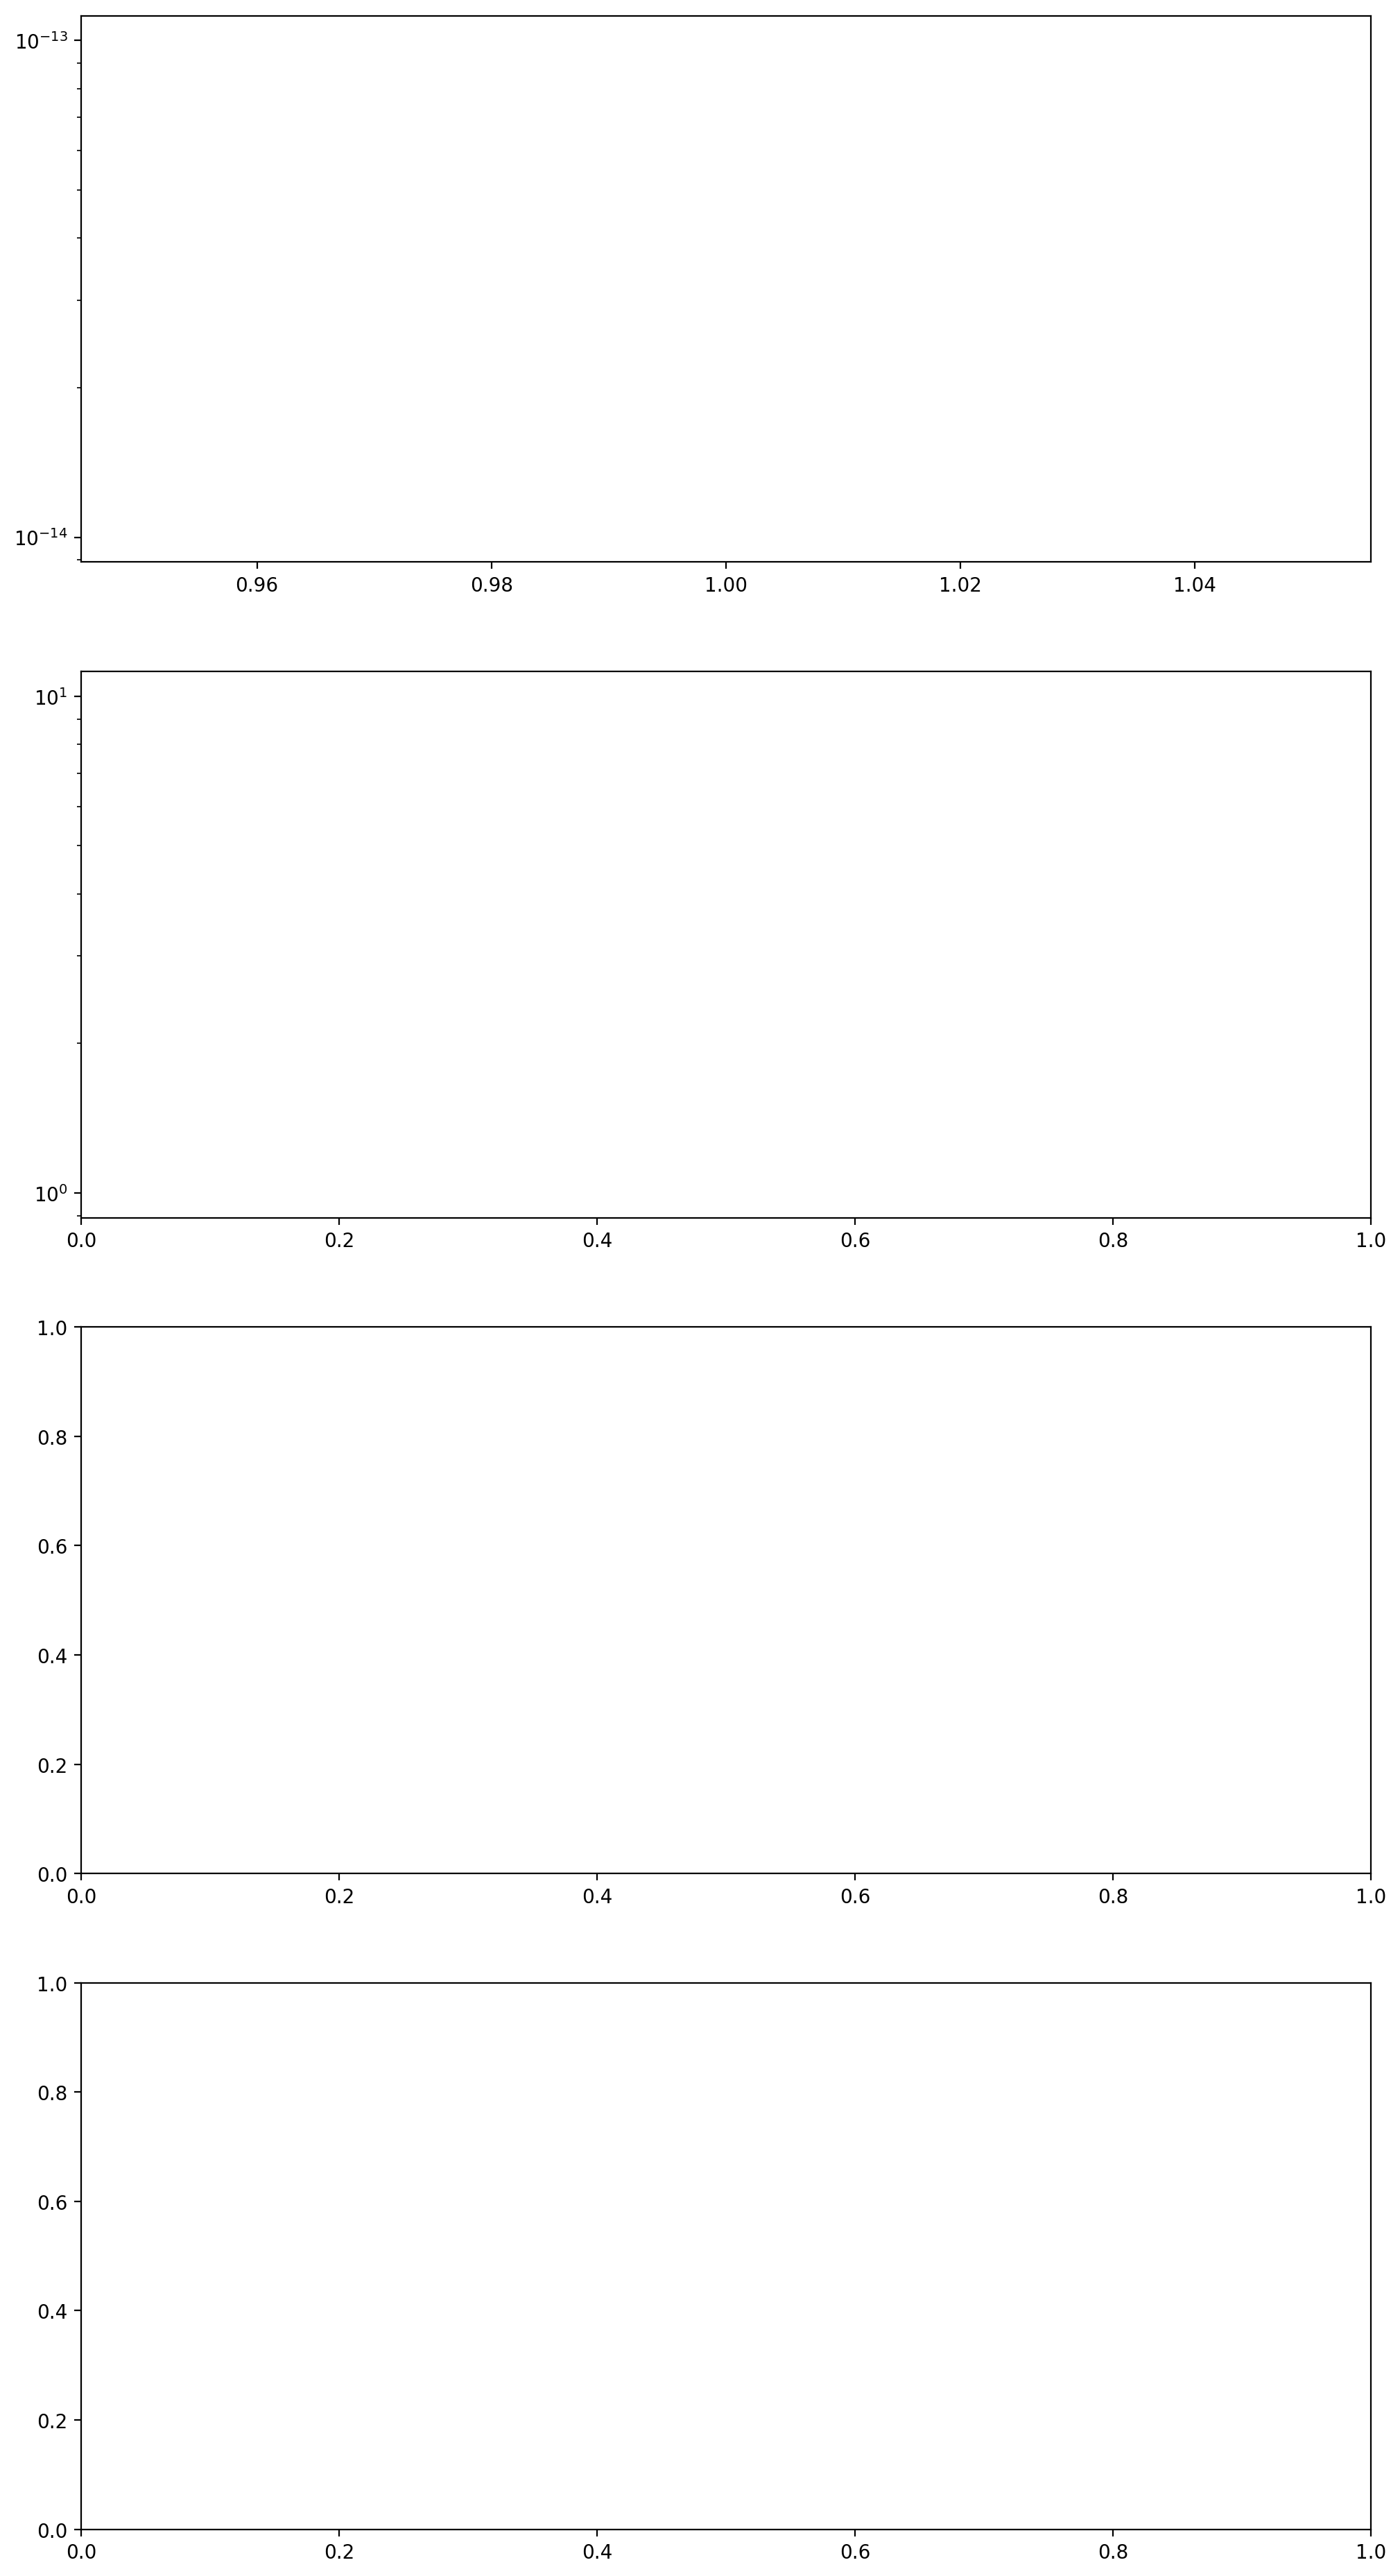

In [25]:
compare(f_stoch, gradf_stoch, hessf_stoch, np.random.rand(N), 1e-8, 1000, [0.5, 0.25])

### Worst-case approximation